##**Image processing using neural networks**

Train a neural network predicting image saliency (amount of gaze fixations in different image regions) based on the experimental data: http://saliency.mit.edu/datasets.html You may use transfer learning and architectures commonly used for image segmentation.

![alt text](http://saliency.mit.edu/exampleImgs/banner.001.png)
![alt text](http://people.csail.mit.edu/tjudd/WherePeopleLook/pics/wherepeoplelookteaser.jpg)

Unzip the training package into Colab:

In [ ]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/Modelling/saliency_MIT_1000_pic.zip" -d "/content"
!unzip -uq "/content/drive/My Drive/Colab Notebooks/Modelling/saliency_MIT_1000_FIXATIONMAPS.zip" -d "/content"

In [ ]:
import numpy as np
import pandas as pd

##Checking dataset resolutions:

width       height
count  1003.000000  1003.000000
mean    962.751745   801.853440
std     118.094228   129.662365
min     577.000000   405.000000
25%    1024.000000   696.500000
50%    1024.000000   768.000000
75%    1024.000000   774.000000
max    1024.000000  1024.000000

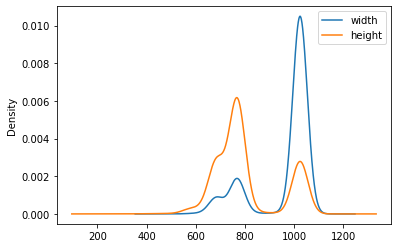

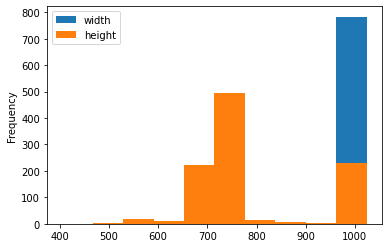

In [ ]:
from PIL import Image ## https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
import os
from os import listdir
from os.path import join

IMGS_DIR = "ALLSTIMULI"      ## xxx.jpeg files
MAPS_DIR = "ALLFIXATIONMAPS" ## xxx_fixMap.jpg files

img_resolution = []
for filename in os.listdir(IMGS_DIR):
  file_path = join(IMGS_DIR,filename)
  if file_path.endswith('.jpeg'):
    img = Image.open(file_path)
    img_resolution += [img.size]

img_resolution = pd.DataFrame(img_resolution, columns=['width','height'])
img_resolution.plot(kind='density')
img_resolution.plot(kind='hist')
img_resolution.describe()

##Data preparation

First let's create a dataframe with paths of images and names of the files:

In [ ]:
df = pd.DataFrame()
X = []
X_names = []
for index, filename in enumerate(os.listdir(IMGS_DIR)):
  file_path = join(IMGS_DIR,filename)
  if file_path.endswith('.jpeg'):
    X_names.append(os.path.splitext(filename)[0])
    X.append(file_path)

df['names'] = pd.Series(X_names)
df['filepaths'] = pd.Series(X)

Lets add column for fixation maps:

In [ ]:
fixation_data = []
for filename in X_names:
  file_path = join(MAPS_DIR,filename + '_fixMap.jpg')
  fixation_data.append(file_path)

df['fixation'] = pd.Series(fixation_data)

Now let's split the set into train/test subsets:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['filepaths', 'names']], df[['fixation','names']], test_size=103)
X_train.describe()

filepaths       names
count                          900         900
unique                         900         900
top     ALLSTIMULI/i161218845.jpeg  i420400353
freq                             1           1

## Keras Dependencies

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.losses import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

Using TensorFlow backend.


##Convolutional:

In [ ]:
#https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/
#https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

def createModel(input_shape, output_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(output_shape[0]*output_shape[1], activation='relu'))
    model.add(Dense(output_shape[0]*output_shape[1], activation='sigmoid'))
    model.add(Reshape(output_shape))

    print(model.summary())
 
    return model

##Alternative U-Net Model:

https://github.com/zhixuhao/unet

![alt text](https://github.com/zhixuhao/unet/raw/master/img/u-net-architecture.png)

In [ ]:
def createModel2(input_shape, output_shape):    
    
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    print(model.summary())

    return model

##Creating data generators for images and saliency maps:

In [ ]:
def createGenerator(input_shape, output_shape, batch_size, evaluation=False):

  data_gen_args = dict(rotation_range=20,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       zoom_range=0.2)

  image_datagen = ImageDataGenerator(preprocessing_function=lambda img: img.astype(int), **data_gen_args)
  map_datagen = ImageDataGenerator(preprocessing_function=lambda img: img/256, **data_gen_args)

  ## IMPORTANT to match operations on the image and fixation map!
  seed = np.random.randint(999999)

  #TODO - check
  #image_datagen.fit(images, augment=True, seed=seed)
  #map_datagen.fit(masks, augment=True, seed=seed)

  if evaluation:
    _X = X_test
    _y = y_test
  else:
    _X = X_train
    _y = y_train

  image_generator = image_datagen.flow_from_dataframe(
      _X,
      x_col="filepaths",
      class_mode=None,
      #color_mode="grayscale",
      target_size=img_size,
      batch_size=batch_size,
      seed=seed)

  map_generator = map_datagen.flow_from_dataframe(
      _y,
      x_col="fixation",
      class_mode=None,
      target_size=map_size,
      color_mode="grayscale",
      batch_size=batch_size,
      seed=seed)
  
  print(map_generator)

  # combine generators into one which yields image and masks
  return zip(image_generator, map_generator)

##Generator test:

Found 900 validated image filenames.
Found 900 validated image filenames.


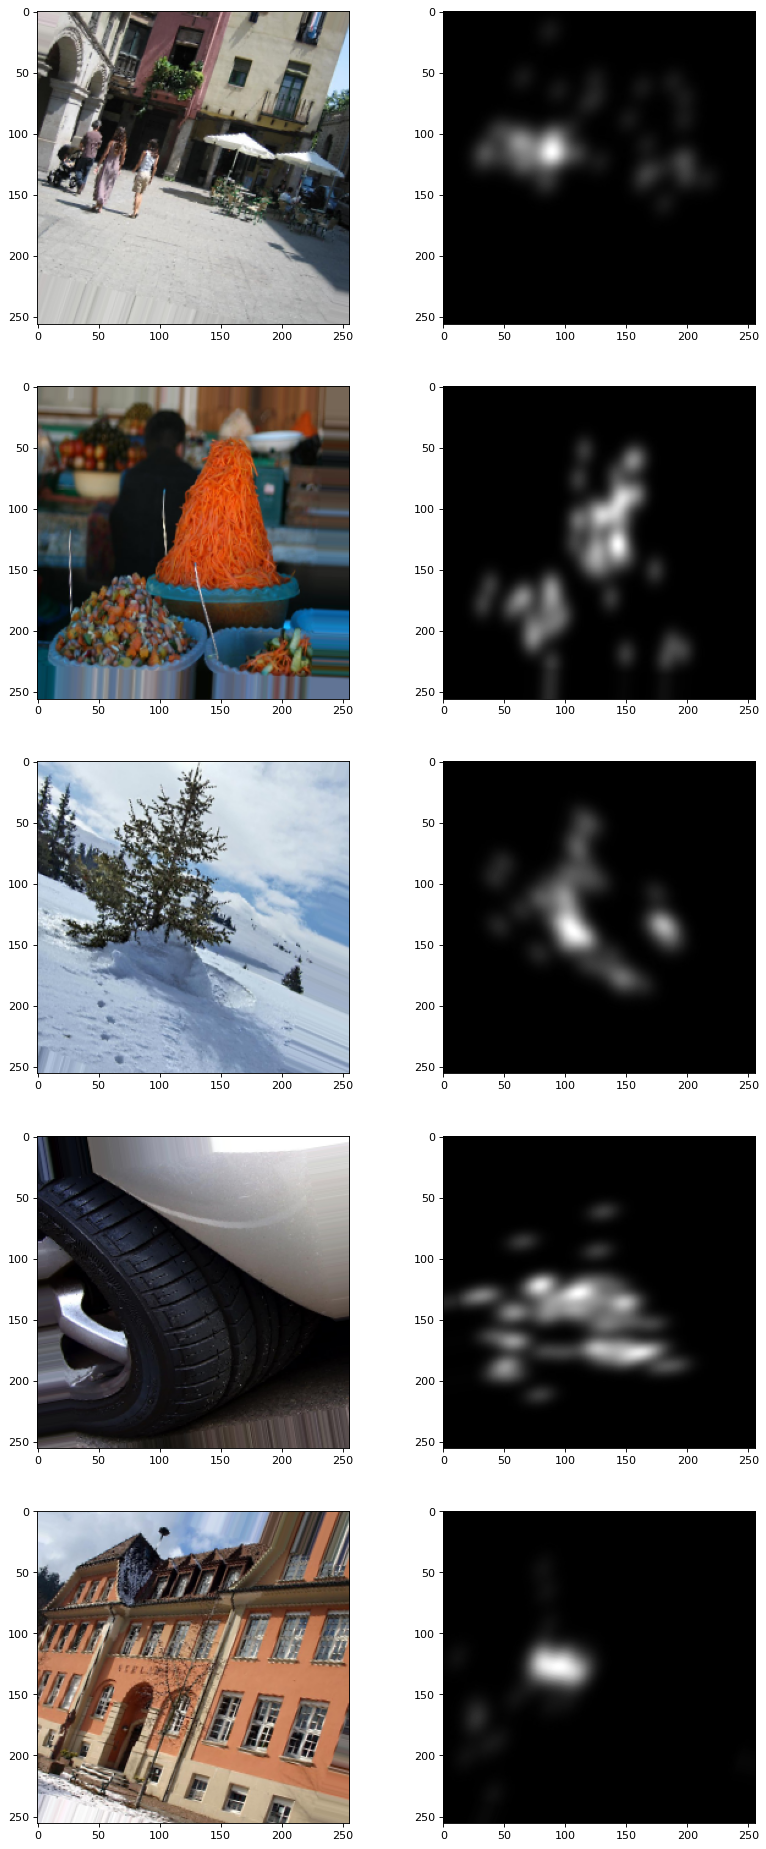

In [ ]:
from matplotlib.pyplot import figure

img_size = (256, 256)
map_size = (256, 256)
batch_size = 5

generator = createGenerator(img_size, map_size, batch_size)

x,y = next(iter(generator))

figure(num=None, figsize=(12, batch_size*6), dpi=80, facecolor='w', edgecolor='k')

for i in range(batch_size):
  plt.subplot(batch_size, 2, 2*i+1)
  plt.imshow(x[i].astype(int))

  plt.subplot(batch_size, 2, 2*i+2)
  plt.imshow(y[i].reshape(256, 256)*256, cmap='gray', vmin=0, vmax=255)

##Creating model:

In [ ]:
img_size = (256, 256)
map_size = (256, 256)

optimizer = Adam(lr=0.0005)
loss = BinaryCrossentropy()

model = createModel2(img_size + (3,), map_size + (1,))

checkpoint = ModelCheckpoint("saliency_model.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Found 900 validated image filenames.
Found 900 validated image filenames.
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 256, 256, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_169[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_170[0][0]                 
__________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


## Training:

In [ ]:
epochs = 25
batch_size = 10

generator = createGenerator(img_size, map_size, batch_size)

history = model.fit_generator(generator,
                              steps_per_epoch=10,#int(np.ceil(900 / float(batch_size))),
                              epochs=epochs,
                              workers=4,
                              callbacks=[checkpoint,early])

Found 900 validated image filenames.
Found 900 validated image filenames.
Epoch 1/25
10/10 [==============================] - 16s 2s/step - loss: 0.1574 - accuracy: 0.6971

Epoch 00001: accuracy did not improve from 0.71176
Epoch 2/25
10/10 [==============================] - 15s 1s/step - loss: 0.1497 - accuracy: 0.6879

Epoch 00002: accuracy did not improve from 0.71176
Epoch 3/25
10/10 [==============================] - 15s 1s/step - loss: 0.1476 - accuracy: 0.6783

Epoch 00003: accuracy did not improve from 0.71176
Epoch 4/25
10/10 [==============================] - 15s 1s/step - loss: 0.1429 - accuracy: 0.7018

Epoch 00004: accuracy did not improve from 0.71176
Epoch 5/25
10/10 [==============================] - 15s 1s/step - loss: 0.1361 - accuracy: 0.7098

Epoch 00005: accuracy did not improve from 0.71176
Epoch 6/25
10/10 [==============================] - 15s 1s/step - loss: 0.1451 - accuracy: 0.6903

Epoch 00006: accuracy did not improve from 0.71176
Epoch 7/25
10/10 [========

Loss/Accurarcy curves:

Text(0.5, 1.0, 'Accuracy Curves')

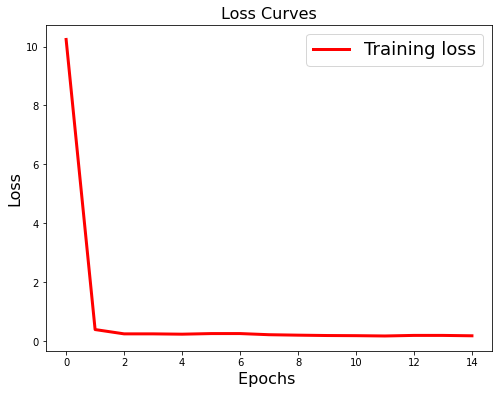

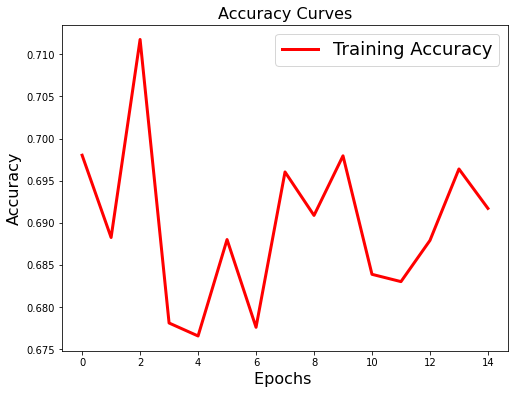

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Let's see an example output of model:

In [ ]:
x,y = next(iter(generator))
model.predict(x)[0]

array([[[2.3938996e-04],
        [1.9213913e-07],
        [1.3545829e-07],
        ...,
        [3.9296710e-06],
        [6.2863583e-06],
        [2.6330483e-04]],

       [[4.0232794e-07],
        [3.5291212e-12],
        [2.2152174e-12],
        ...,
        [3.3619791e-08],
        [3.7386867e-09],
        [2.4486098e-06]],

       [[1.1971778e-07],
        [7.9431330e-11],
        [3.5817480e-10],
        ...,
        [1.6389079e-07],
        [1.6187448e-08],
        [5.2403811e-06]],

       ...,

       [[1.0525514e-01],
        [4.2662553e-02],
        [3.8397938e-02],
        ...,
        [1.4851370e-09],
        [1.8681803e-09],
        [5.1906719e-09]],

       [[1.6183558e-01],
        [3.4709573e-02],
        [2.9083086e-02],
        ...,
        [1.6324151e-08],
        [1.3109475e-07],
        [2.8533241e-06]],

       [[1.1781385e-01],
        [4.7833346e-02],
        [4.0083982e-02],
        ...,
        [1.5513376e-06],
        [3.5075864e-05],
        [1.4933794e-14]]

## Evaluate Model:

In [ ]:
evaluation_generator = createGenerator(img_size, map_size, batch_size=4, evaluation=True)

model.evaluate_generator(evaluation_generator, steps=1, workers=4)

Found 103 validated image filenames.
Found 103 validated image filenames.


[0.17613866925239563, 0.6660919189453125]

Loss: 0.17613866925239563

Accuracy: 0.6660919189453125

## Visualization:

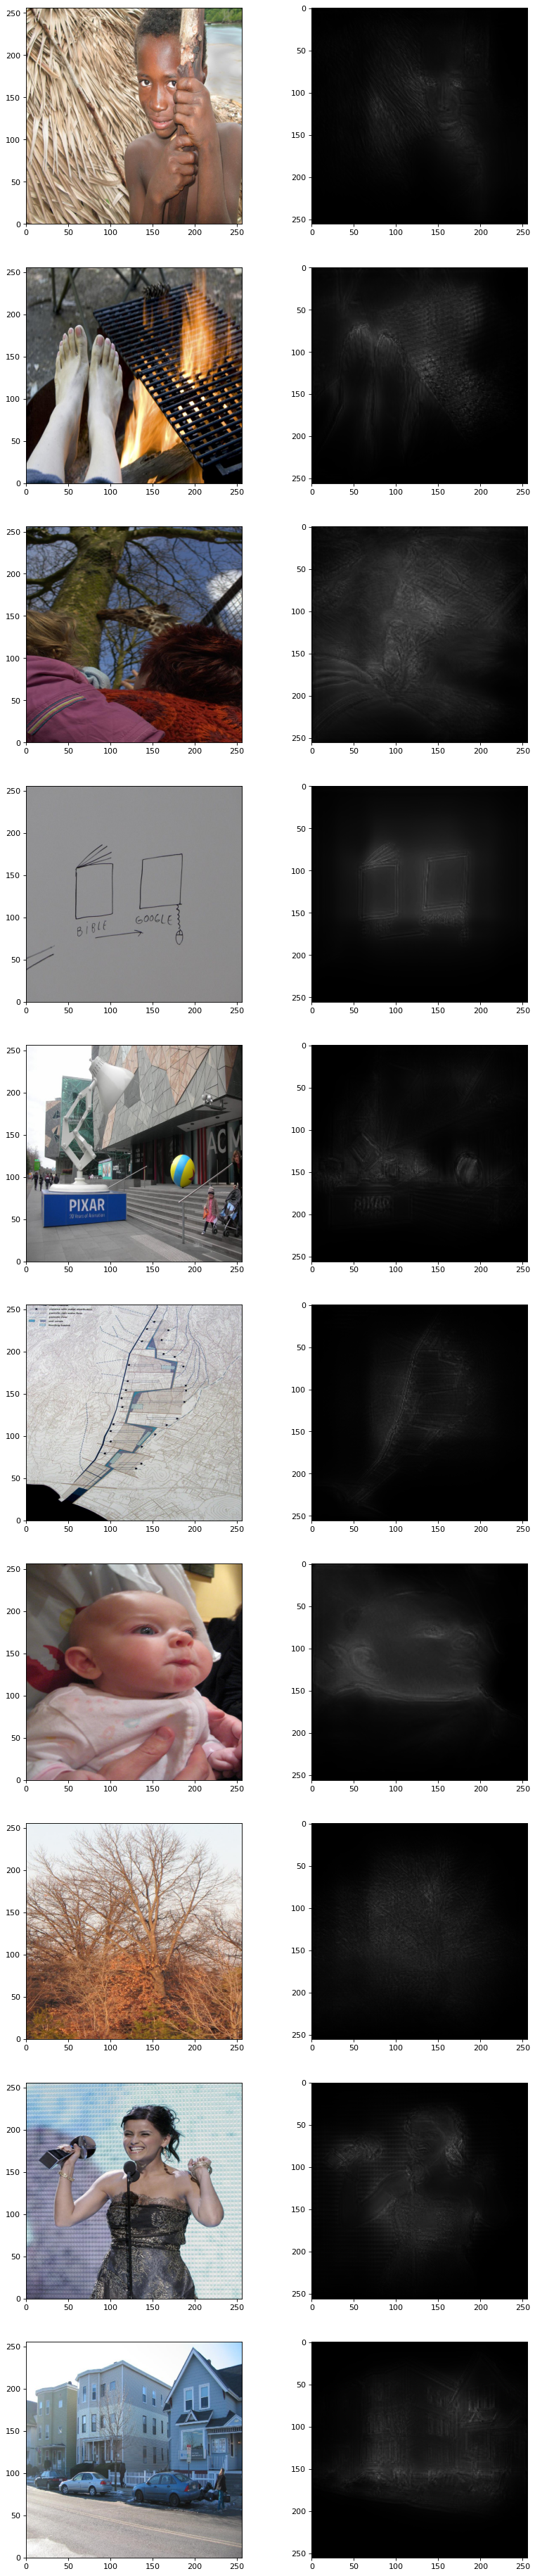

In [ ]:
examples = 10

all_files = [filename for filename in os.listdir(IMGS_DIR)]
random_vals = np.random.randint(len(all_files), size=(1, examples))

figure(num=None, figsize=(12, examples*6), dpi=80, facecolor='w', edgecolor='k')

for index, random_no in enumerate(random_vals[0]):
  with open(join(IMGS_DIR, all_files[random_no]), 'r+b') as f:
      with Image.open(f) as img:
          cover = img.resize(img_size).convert(mode='RGB')
          cover = np.array(cover.getdata()).reshape((1,) + cover.size + (3,))
          fixation_map = model.predict(cover)[0]
 
          plt.subplot(examples, 2, 2*index+1)
          plt.imshow(img, extent=[0,256,0,256])

          plt.subplot(examples, 2, 2*index+2)
          plt.imshow(fixation_map.reshape(map_size)*256, cmap='gray', vmin=0, vmax=255)

i1465804180.jpeg


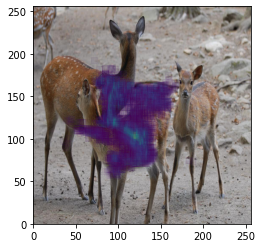

i2271293627.jpeg


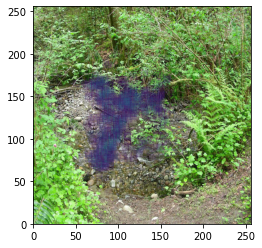

i2308842869.jpeg


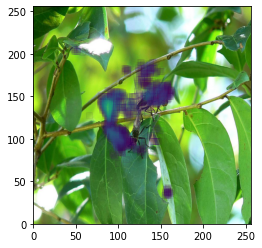

i2169308750.jpeg


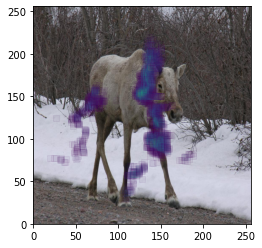

istatic_park_outdoor_boston_IMG_0134.jpeg


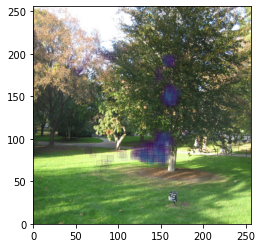

In [ ]:
from random import randint

all_files = [filename for filename in os.listdir(IMGS_DIR)]
random_vals = np.random.randint(len(all_files), size=(1, 5))

for i in np.nditer(random_vals):
  print(all_files[i])
  with open(join(IMGS_DIR, all_files[i]), 'r+b') as f:
      with Image.open(f) as img:
          cover = img.resize(img_size).convert(mode='RGB')
          cover = np.array(cover.getdata()).reshape((1,) + cover.size + (3,))
          fixation_map = model.predict(cover)[0]
          chosen = np.where(fixation_map > 0.17)
          plt.imshow(img, extent=[0,256,0,256])
          plt.scatter(chosen[0], chosen[1], c=fixation_map[chosen], alpha=0.05, marker=',')

  plt.show()